# Classification Test
This notebook contains the analysis of classification performance
and lexicon similarity as describe in the example usages section. 


In [1]:
# Data from https://www.kaggle.com/c/twitter-sentiment-analysis2/data

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

from nltk import word_tokenize

from social_sent_helpers import list_lexicons, read_lexicon, games_list, sports_list, read_all_lexicons
from qlex import los

from bokeh.plotting import ColumnDataSource, figure, output_notebook, show
from bokeh.models.widgets import DataTable
from bokeh.models import TableColumn, Span
from bokeh.layouts import Column, Row

output_notebook()

c:\users\felix\nlp\.venv\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Loading BokehJS ...

In [3]:
tweets = pd.read_csv("./sentimest_test_sets/tweets.csv", encoding = "ISO-8859-1")
tweets.columns = ["id", "sent", "text"]
tweets.set_index("id", inplace=True)
tweets.head()

sent                                               text
id                                                         
1      0                       is so sad for my APL frie...
2      0                     I missed the New Moon trail...
3      1                            omg its already 7:30 :O
4      0            .. Omgaga. Im sooo  im gunna CRy. I'...
5      0           i think mi bf is cheating on me!!!   ...

1599999


sent                                               text
id                                                                 
1467810672     0  is upset that he can't update his Facebook by ...
1467810917     0  @Kenichan I dived many times for the ball. Man...
1467811184     0    my whole body feels itchy and like its on fire 
1467811193     0  @nationwideclass no, it's not behaving at all....
1467811372     0                      @Kwesidei not the whole crew

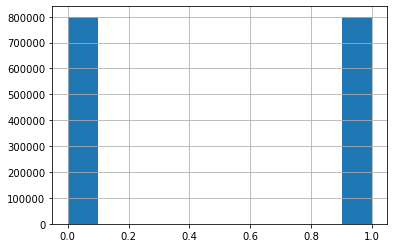

In [4]:
# Only needs to be loaded, if 
# Can be downloaded from here (just one option): https://www.kaggle.com/kazanova/sentiment140
if False: 
    sent140 = pd.read_csv("./sentimest_test_sets/training.1600000.processed.noemoticon.csv", 
                                  encoding = "ISO-8859-1", sep=",")
    sent140.columns = ["sent", "id", "time", "none1", "none2", "text"]
    sent140.drop(["time", "none1", "none2"], axis=1, inplace=True)
    sent140.sent = sent140.sent.map(lambda x: x // 4)
    sent140.set_index("id", inplace=True)
    print(len(sent140))
    sent140.sent.hist()
    sent140.head()

6163


sent                                               text
id                                                                         
801989272341453952     1  Ariana Grande KIIS FM Yours Truly CD listening...
801990978424962944     1  Ariana Grande White House Easter Egg Roll in W...
801996232553963008     1  #CD #Musics Ariana Grande Sweet Like Candy 3.4...
802001659970744064     1  Hairspray Live! Previews at the Macy's Thanksg...
802003380973568000     1  #LindsayLohan Is âFeeling Thankfulâ After ...

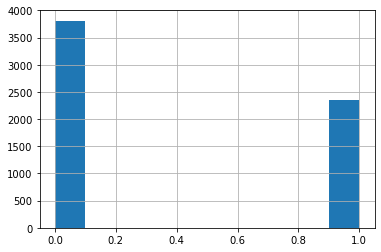

In [5]:
sem_eval_tweets = pd.read_csv("./sentimest_test_sets/SemEval2017-task4-test.subtask-A.english.txt", 
                              encoding = "ISO-8859-1", sep="\t")
sem_eval_tweets.columns = ["id", "sent", "text"]
sem_eval_tweets = sem_eval_tweets[sem_eval_tweets.sent.isin(["positive", "negative"])]
sem_eval_tweets.sent = sem_eval_tweets.sent.map(lambda x: int(x.startswith("p")))
sem_eval_tweets.set_index("id", inplace=True)
print(len(sem_eval_tweets))
sem_eval_tweets.sent.hist()
sem_eval_tweets.head()

In [6]:
movie_lex = read_lexicon("movies")
lex_dict = movie_lex.set_index("word").so.to_dict()

In [7]:
with open('twitter_lexicon_decimals.json') as json_file:
    twitter_lex = json.load(json_file)

In [8]:
def get_sentiment(text):
    return np.mean([lex_dict[token] for token in word_tokenize(text) if token in lex_dict] + [0])
''
def sent_from_lex(text, lex_dict):
    return np.mean([lex_dict[token] for token in word_tokenize(text) if token in lex_dict] + [0])

def get_lexicon_performance(texts, ratings, lexicon):
    preds = np.array([int(sent_from_lex(text, lexicon) > 0) for text in tqdm(texts, leave=False)])
    ratings = np.array(ratings)
    return 1 - (np.sum(np.abs(ratings - preds)) / len(texts))
    
get_lexicon_performance(["hallo", "test", "hallo test"], [1, 0, 1], {"hallo": 1, "test": -0.8})

1.0

In [9]:
get_lexicon_performance(tweets.text, tweets.sent, twitter_lex)

0.6036864055046055

In [10]:
get_lexicon_performance(sem_eval_tweets.text, sem_eval_tweets.sent, twitter_lex)

0.6013305208502353

In [ ]:
#get_lexicon_performance(sent140.text, sent140.sent, twitter_lex)

In [12]:
twitter_lex_df = pd.DataFrame.from_dict(twitter_lex, orient="index").reset_index()
twitter_lex_df.columns = ["word", "so"]
twitter_lex_df.sample(3)

word     so
947      whole  0.454
1134  nowadays  0.234
1137   hideous -0.750

In [ ]:
def los_score_distr(tweet_df):
    res = []
    for lex_name, lex in zip(tqdm(list_lexicons()), read_all_lexicons()):
        res.append([
            lex_name,
            los.simple(twitter_lex_df, lex),
            los.binary(twitter_lex_df, lex),
            los.score(twitter_lex_df, lex),
            get_lexicon_performance(tweet_df.text, tweet_df.sent, lex.set_index("word").so.to_dict())
        ])
    return pd.DataFrame(res, columns=["lex", "simple", "binary", "score", "perf"])

In [22]:
df = los_score_distr(tweets.sample(30000))

In [13]:
df = pd.read_pickle("twitter_with_dec_los_scores.pickle")

Text(0.5, 1.0, 'Classification accuracy and lexicon similarity')

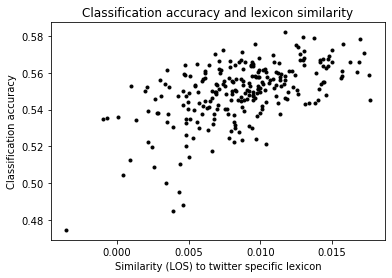

In [18]:
plt.plot(df.score, df.perf, "k.")
plt.xlabel("Similarity (LOS) to twitter specific lexicon")
plt.ylabel("Classification accuracy")
plt.title("Classification accuracy and lexicon similarity")

In [19]:
df.corr()

simple    binary     score      perf
simple  1.000000  0.836084  0.112788 -0.124283
binary  0.836084  1.000000  0.594074  0.254469
score   0.112788  0.594074  1.000000  0.553233
perf   -0.124283  0.254469  0.553233  1.000000

In [21]:
data_source = ColumnDataSource(df)

p = figure(plot_width=600, plot_height=400, tooltips="@lex", 
           title="Scatter Plot (LOS v3)", 
           tools="pan,lasso_select,box_select", x_axis_label="LOS score", y_axis_label="Performance")

p.circle('score', 'perf', size=5, source=data_source)
show(p)